Sveučilište u Zagrebu  
Fakultet elektrotehnike i računarstva  
  
## Strojno učenje 1 2023/2024  
http://www.fer.unizg.hr/predmet/struce1

------------------------------

### Druga laboratorijska vježba: Linearni diskriminativni modeli i logistička regresija

*Verzija: 1.1 (ispravljena greška u tekstu prvog zadatka)  
Zadnji put ažurirano: 1. 10. 2021.*

(c) 2015-2023 Jan Šnajder, Domagoj Alagić  

Rok za predaju: **5. studenog 2023. u 23:59h**

------------------------------

### Pravila predaje
Predajom vježbe potvrđujete sljedeće točke:
1. Niste od drugoga primili pomoć pri rješavanju vježbe;
2. Atribuirali ste dijelove koda koji su preuzeti s interneta referencirajući ih u komentarima;
3. Niste koristili dijelove koda s interneta koji su specifični za laboratorijsku vježbu;
4. Niste koristili UI-asistente za kodiranje kao npr. GitHub Copilot (uključivo alate generativne UI, kao što je ChatGPT).

**Povreda bilo kojeg od gornjih pravila smatra se prekršajem te povlači akademske sankcije.**

### Upute

Druga laboratorijska vježba sastoji se od šest zadataka. U nastavku slijedite upute navedene u ćelijama s tekstom. Rješavanje vježbe svodi se na **dopunjavanje ove bilježnice**: umetanja ćelije ili više njih **ispod** teksta zadatka, pisanja odgovarajućeg kôda te evaluiranja ćelija.

Osigurajte da u potpunosti **razumijete** kôd koji ste napisali. Kod predaje vježbe, morate biti u stanju na zahtjev asistenta (ili demonstratora) preinačiti i ponovno evaluirati Vaš kôd. Nadalje, morate razumjeti teorijske osnove onoga što radite, u okvirima onoga što smo obradili na predavanju. Ispod nekih zadataka možete naći i pitanja koja služe kao smjernice za bolje razumijevanje gradiva (**nemojte pisati** odgovore na pitanja u bilježnicu). Stoga se nemojte ograničiti samo na to da riješite zadatak, nego slobodno eksperimentirajte. To upravo i jest svrha ovih vježbi.

Vježbe trebate raditi **samostalno**. Možete se konzultirati s drugima o načelnom načinu rješavanja, ali u konačnici morate sami odraditi vježbu. U protivnome vježba nema smisla.

In [1]:
# !!!!! VAZNO !!!!!
# Ponavljac sam ovog predmeta, stoga:
# Kod u nastavku labosa je moj kod iz ak.god. 22./23. s kojim sam bila zadovoljna/za koji sam dobila bodove
# Uz eventualne manje promjene/dodatke onoga sto nisam rijesila prosle godine
# (Prijenosa labosa nema na predmetu, ali smijemo braniti svoje stare labose :) )

# Učitaj osnovne biblioteke...
import sklearn
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
def plot_2d_clf_problem(X, y, h=None):
    '''
    Plots a two-dimensional labeled dataset (X,y) and, if function h(x) is given,
    the decision surfaces.
    '''
    assert X.shape[1] == 2, "Dataset is not two-dimensional"
    if h!=None :
        # Create a mesh to plot in
        r = 0.04  # mesh resolution
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, r),
                             np.arange(y_min, y_max, r))
        XX=np.c_[xx.ravel(), yy.ravel()]
        try:
            Z_test = h(XX)
            if Z_test.shape == ():
                # h returns a scalar when applied to a matrix; map explicitly
                Z = np.array(list(map(h,XX)))
            else :
                Z = Z_test
        except ValueError:
            # can't apply to a matrix; map explicitly
            Z = np.array(list(map(h,XX)))
        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        plt.contourf(xx, yy, Z, cmap=plt.cm.Pastel1)

    # Plot the dataset
    plt.scatter(X[:,0],X[:,1], c=y, cmap=plt.cm.tab20b, marker='o', s=50);

### 1. Linearna regresija kao klasifikator

U prethodnoj laboratorijskoj vježbi koristili smo model linearne regresije za, naravno, regresiju. Međutim, model linearne regresije može se koristiti i za **klasifikaciju**. Iako zvuči pomalo kontraintuitivno, zapravo je dosta jednostavno. Naime, cilj je naučiti funkciju $f(\mathbf{x})$ koja za pozitivne primjere predviđa vrijednost $1$, dok za negativne primjere predviđa vrijednost $0$. U tom slučaju, funkcija $f(\mathbf{x})=0.5$ predstavlja granicu između klasa, tj. primjeri za koje vrijedi $h(\mathbf{x})\geq 0.5$ klasificiraju se kao pozitivni, dok se ostali klasificiraju kao negativni.

Klasifikacija pomoću linearne regresije implementirana je u razredu [`RidgeClassifier`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeClassifier.html). U sljedećim podzadatcima **istrenirajte** taj model na danim podatcima i **prikažite** dobivenu granicu između klasa. Pritom isključite regularizaciju ($\alpha = 0$, odnosno `alpha=0`). Također i ispišite **točnost** vašeg klasifikacijskog modela (smijete koristiti funkciju [`metrics.accuracy_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html)). Skupove podataka vizualizirajte korištenjem pomoćne funkcije ``plot_clf_problem(X, y, h=None)`` koja je dana na početku ove bilježnice. `X` i `y` predstavljaju ulazne primjere i oznake, dok `h` predstavlja funkciju predikcije modela (npr. `model.predict`).

U ovom zadatku cilj je razmotriti kako se klasifikacijski model linearne regresije ponaša na linearno odvojim i neodvojivim podatcima.

In [3]:
from sklearn.linear_model import LinearRegression, RidgeClassifier
from sklearn.metrics import accuracy_score

### (a)

Prvo, isprobajte *ugrađeni* model na linearno odvojivom skupu podataka `seven` ($N=7$).

In [4]:
seven_X = np.array([[2,1], [2,3], [1,2], [3,2], [5,2], [5,4], [6,3]])
seven_y = np.array([1, 1, 1, 1, 0, 0, 0])

Accracy score: 1.0


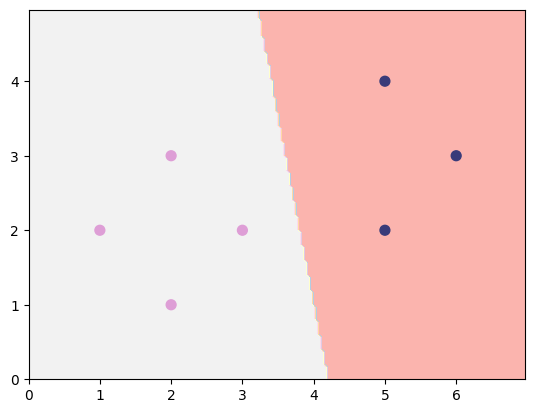

In [5]:
model1a = RidgeClassifier(alpha=0)
model1a.fit(seven_X, seven_y)
h1a = model1a.predict(seven_X)
#print(h1a)

plot_2d_clf_problem(seven_X, seven_y, model1a.predict)
print("Accracy score: "+ str(accuracy_score(seven_y, h1a)))

Kako bi se uvjerili da se u isprobanoj implementaciji ne radi o ničemu doli o običnoj linearnoj regresiji, napišite kôd koji dolazi do jednakog rješenja korištenjem isključivo razreda [`LinearRegression`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html). Funkciju za predikciju, koju predajete kao treći argument `h` funkciji `plot_2d_clf_problem`, možete definirati lambda-izrazom: `lambda x : model.predict(x) >= 0.5`.

Accracy score: 1.0


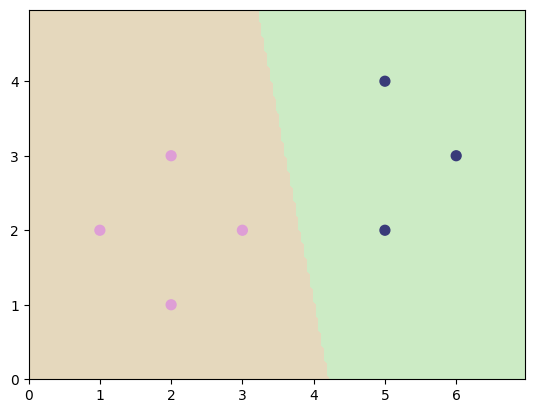

In [6]:
model1a_lin = LinearRegression().fit(seven_X, seven_y)
h1a_lin = model1a.predict(seven_X)
plot_2d_clf_problem(seven_X, seven_y, lambda x : model1a_lin.predict(x) >= 0.5)
print("Accracy score: "+ str(accuracy_score(seven_y, h1a)))

**Q:** Kako bi bila definirana granica između klasa ako bismo koristili oznake klasa $-1$ i $1$ umjesto $0$ i $1$?

### (b)  

Probajte isto na linearno odvojivom skupu podataka `outlier` ($N=8$):

In [7]:
outlier_X = np.append(seven_X, [[12,8]], axis=0)
outlier_y = np.append(seven_y, 0)

Accracy score: 0.875


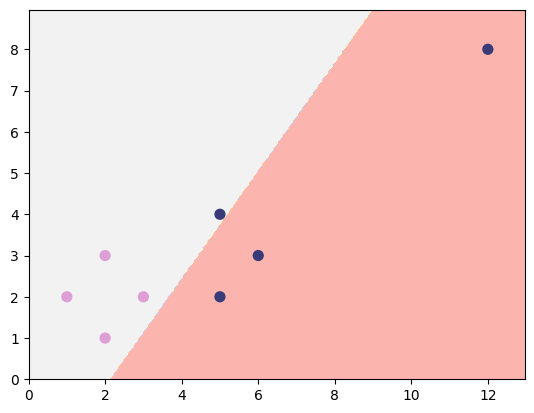

In [8]:
model1b = RidgeClassifier(alpha=0)
model1b.fit(outlier_X, outlier_y)
h1b = model1b.predict(outlier_X)
#print(h1a)

plot_2d_clf_problem(outlier_X, outlier_y, model1b.predict)
print("Accracy score: "+ str(accuracy_score(outlier_y, h1b)))

**Q:** Zašto model ne ostvaruje potpunu točnost iako su podatci linearno odvojivi?

### (c)  

Završno, probajte isto na linearno neodvojivom skupu podataka `unsep` ($N=8$):

In [9]:
unsep_X = np.append(seven_X, [[2,2]], axis=0)
unsep_y = np.append(seven_y, 0)

Accracy score: 0.875


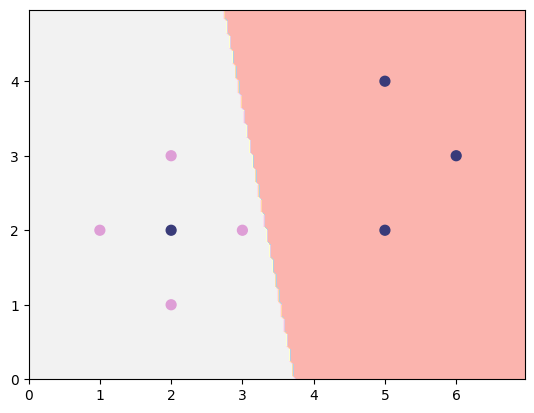

In [10]:
model1c = RidgeClassifier(alpha=0)
model1c.fit(unsep_X, unsep_y)
h1c = model1c.predict(unsep_X)
#print(h1a)

plot_2d_clf_problem(unsep_X, unsep_y, model1c.predict)
print("Accracy score: "+ str(accuracy_score(unsep_y, h1c)))

**Q:** Očito je zašto model nije u mogućnosti postići potpunu točnost na ovom skupu podataka. Međutim, smatrate li da je problem u modelu ili u podacima? Argumentirajte svoj stav.

### 2. Višeklasna klasifikacija

Postoji više načina kako se binarni klasifikatori mogu se upotrijebiti za višeklasnu klasifikaciju. Najčešće se koristi shema tzv. **jedan-naspram-ostali** (engl. *one-vs-rest*, OVR), u kojoj se trenira po jedan klasifikator $h_j$ za svaku od $K$ klasa. Svaki klasifikator $h_j$ trenira se da razdvaja primjere klase $j$ od primjera svih drugih klasa, a primjer se klasificira u klasu $j$ za koju je $h_j(\mathbf{x})$ maksimalan.

Pomoću funkcije [`datasets.make_classification`](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html) generirajte slučajan dvodimenzijski skup podataka od tri klase i prikažite ga koristeći funkciju `plot_2d_clf_problem`. Radi jednostavnosti, pretpostavite da nema redundantnih značajki te da je svaka od klasa "zbijena" upravo u jednu grupu.

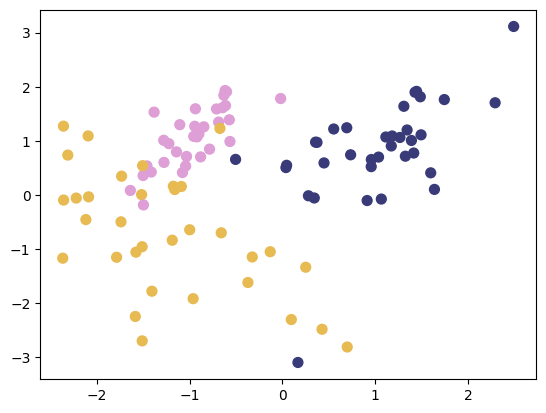

In [20]:
from sklearn.datasets import make_classification

X2, y2 = make_classification(n_features=2, n_redundant=0, n_classes=3,  n_clusters_per_class=1)
plot_2d_clf_problem(X2, y2)
#y je 0, 1 ili 2

Trenirajte tri binarna klasifikatora, $h_1$, $h_2$ i $h_3$ te prikažite granice između klasa (tri grafikona). Zatim definirajte $h(\mathbf{x})=\mathrm{argmax}_j h_j(\mathbf{x})$  (napišite svoju funkciju `predict` koja to radi) i prikažite granice između klasa za taj model. Zatim se uvjerite da biste identičan rezultat dobili izravno primjenom modela `RidgeClassifier`, budući da taj model za višeklasan problem zapravo interno implementira shemu jedan-naspram-ostali.

**Q:** Alternativna shema jest ona zvana **jedan-naspram-jedan** (engl, *one-vs-one*, OVO). Koja je prednost sheme OVR nad shemom OVO? A obratno?

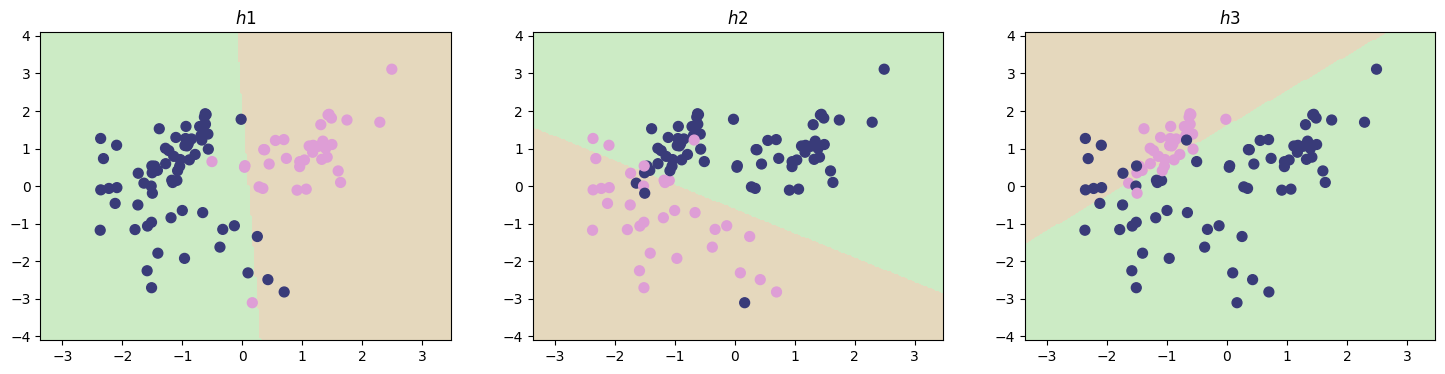

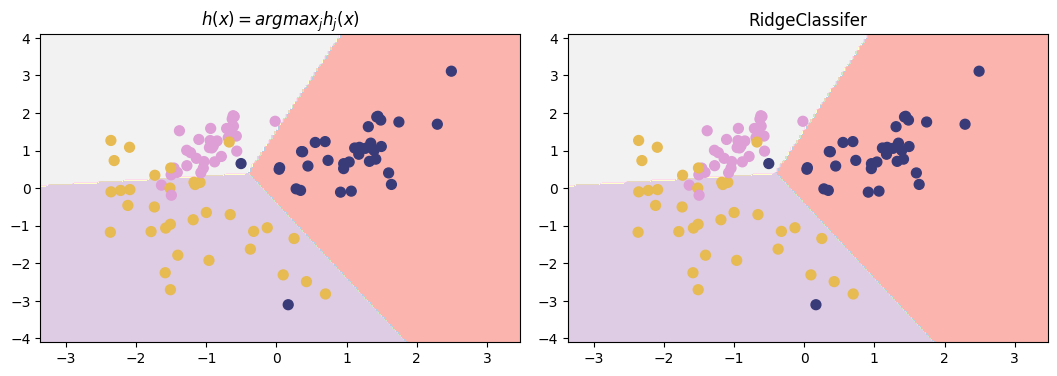

In [21]:
y21 = []
y22 = []
y23 = []

for i in y2:
    if i == 0: # h1
        y21.append(1)
        y22.append(0)
        y23.append(0)
    elif i==1: # h2
        y21.append(0)
        y22.append(1)
        y23.append(0)
    elif i==2: # h3
        y21.append(0)
        y22.append(0)
        y23.append(1)
    else: #neki krivi broj
        break

linreg21 = LinearRegression().fit(X2, y21)

linreg22 = LinearRegression().fit(X2, y22)

linreg23 = LinearRegression().fit(X2, y23)

#print("ok")
plt.figure(figsize= (18, 4))
#print("ok")
plt.subplots_adjust(wspace=0.2)

plt.subplot(1,3,1)
plot_2d_clf_problem(X2, y21, lambda x: linreg21.predict(x) >= 0.5)
plt.title('$h1$')

plt.subplot(1,3,2)
plot_2d_clf_problem(X2, y22, lambda x: linreg22.predict(x) >= 0.5)
plt.title('$h2$')

plt.subplot(1,3,3)
plot_2d_clf_problem(X2, y23, lambda x: linreg23.predict(x) >= 0.5)
plt.title('$h3$')

#print("Grafovi za 3 različita h,")

##sada dio za argmax
#x=X2[0]
#print(x)
#print(x.reshape(1, -1))
argmax_h = lambda x: np.argmax([linreg21.predict(x.reshape(1, -1)), linreg22.predict(x.reshape(1, -1)), linreg23.predict(x.reshape(1, -1))])
plt.figure(figsize= (13, 4));
plt.subplots_adjust(wspace=0.1)
plt.subplot(1, 2, 1)
plot_2d_clf_problem(X2, y2, argmax_h)
plt.title('$h(x) = argmax_jh_j(x)$')

ridgereg2 = RidgeClassifier(alpha = 0)
ridgereg2.fit(X2, y2)

plt.subplot(1, 2, 2)
plot_2d_clf_problem(X2, y2, ridgereg2.predict)
plt.title('RidgeClassifer')
plt.show()


### 3. Logistička regresija

Ovaj zadatak bavi se probabilističkim diskriminativnim modelom, **logističkom regresijom**, koja je, unatoč nazivu, klasifikacijski model.

Logistička regresija tipičan je predstavnik tzv. **poopćenih linearnih modela** koji su oblika: $h(\mathbf{x})=f(\mathbf{w}^\intercal\tilde{\mathbf{x}})$. Logistička funkcija za funkciju $f$ koristi tzv. **logističku** (sigmoidalnu) funkciju $\sigma (x) = \frac{1}{1 + \textit{exp}(-x)}$.

### (a)  

Definirajte logističku (sigmoidalnu) funkciju $\mathrm{sigm}(x)=\frac{1}{1+\exp(-\alpha x)}$ i prikažite je za $\alpha\in\{1,2,4\}$.

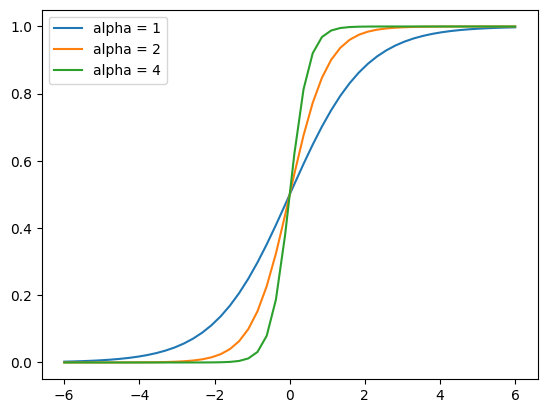

In [22]:
def sigmoid(arg): return 1/(1 + exp(-arg)) #sigmoida

#grafovi sigmoide
x3a = np.linspace(-6,6)
alphas = [1, 2, 4]
plt.figure()
for i in alphas:
  plt.plot(x3a, sigmoid(i*x3a))
plt.legend(['alpha = 1', 'alpha = 2', 'alpha = 4'])
plt.show()

**Q**: Zašto je sigmoidalna funkcija prikladan izbor za aktivacijsku funkciju poopćenoga linearnog modela?
</br>

**Q**: Kakav utjecaj ima faktor $\alpha$ na oblik sigmoide? Što to znači za model logističke regresije (tj. kako izlaz modela ovisi o normi vektora težina $\mathbf{w}$)?

### (b)

Implementirajte funkciju

> `lr_train(X, y, eta=0.01, max_iter=2000, alpha=0, epsilon=0.0001, trace=False)`

za treniranje modela logističke regresije gradijentnim spustom (*batch* izvedba). Funkcija uzima označeni skup primjera za učenje (matrica primjera `X` i vektor oznaka `y`) te vraća $(n+1)$-dimenzijski vektor težina tipa `ndarray`. Ako je `trace=True`, funkcija dodatno vraća listu (ili matricu) vektora težina $\mathbf{w}^0,\mathbf{w}^1,\dots,\mathbf{w}^k$ generiranih kroz sve iteracije optimizacije, od 0 do $k$. Optimizaciju treba provoditi dok se ne dosegne `max_iter` iteracija, ili kada razlika u pogrešci unakrsne entropije između dviju iteracija padne ispod vrijednosti `epsilon`. Parametar `alpha` predstavlja faktor L2-regularizacije.

Preporučamo definiranje pomoćne funkcije `lr_h(x,w)` koja daje predikciju za primjer `x` uz zadane težine `w`. Također, preporučamo i funkciju `cross_entropy_error(X,y,w)` koja izračunava pogrešku unakrsne entropije modela na označenom skupu `(X,y)` uz te iste težine.

**NB:** Obratite pozornost na to da je način kako su definirane oznake ($\{+1,-1\}$ ili $\{1,0\}$) kompatibilan s izračunom funkcije gubitka u optimizacijskome algoritmu.

In [29]:
from numpy import linalg
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import log_loss

def lr_h(x, w):
    fi = PolynomialFeatures(1).fit_transform(x.reshape(1,-1)) #dummy jedinice
    return sigmoid(fi.dot(w))

def cross_entropy_error(X, y, w):
    N = len(y)
    s = -y[0] * np.log(lr_h(X[0], w)) - (1 - y[0]) * np.log(1 - lr_h(X[0], w))
    for i in range(N):
      if i != 0: ##prvi clan je vec dodan u sumu s pa njega preskacemo
        err = -y[i] * np.log(lr_h(X[i], w)) - (1 - y[i]) * np.log(1 - lr_h(X[i], w))
        s+=err
    return s* 1/N



def lr_train(X, y, eta = 0.01, max_iter = 2000, alpha = 0, epsilon = 0.0001, trace= False):
    weights = np.zeros(np.shape(X)[1] + 1) # vektor [0. 0. 0.] kao početni za težine
    N = len(y) #broj primjera
    w_track = []
    prev_err = epsilon**-1 #za početak prethodni error stavimo u veliki broj

    for i in range(0, max_iter):
        dw0 = 0 #početna vrijednost za w0
        dw = np.zeros(np.shape(X)[1]) # vektor [0. 0.] kao početni za težine w1 i w2
        err = 0

        for p in range(0, N):
            h = lr_h(X[p], weights)
            dw0 += h - y[p]
            dw += (h - y[p])*X[p]
            tmp_err = -y[p] * np.log(h) - (1 - y[p]) * np.log(1 - h) #cross entropy loss u ovom koraku
            err += tmp_err

        if abs(prev_err - err) < epsilon:
            print('epsilon uvjet na i = ' + str(i))
            break

        else: prev_err = err

        weights[0] -= dw0*eta #gradijent formula
        weights[1:] = weights[1:] * (1-eta*alpha) - eta*dw #gradijent formula

        w_track.extend(weights)

    if trace:
        return weights, w_track

    else:
        return weights

### (c)

Koristeći funkciju `lr_train`, trenirajte model logističke regresije na skupu `seven`, prikažite dobivenu granicu između klasa te  izračunajte pogrešku unakrsne entropije.

**NB:** Pripazite da modelu date dovoljan broj iteracija.

In [31]:
seven_X = np.array([[2,1], [2,3], [1,2], [3,2], [5,2], [5,4], [6,3]])
seven_y = np.array([1, 1, 1, 1, 0, 0, 0])

E(w|D) = 0.07751718252492557
w0 = 6.441509591566677
w1 = -2.110121276021104
w2 = 0.5352285063324532


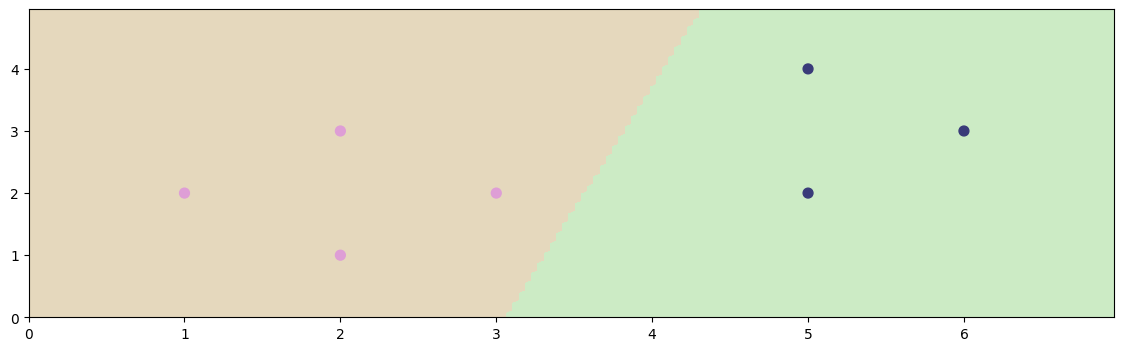

In [32]:
weights3d = lr_train(seven_X, seven_y)
print("E(w|D) = "+ str(cross_entropy_error(seven_X, seven_y, weights3d)[0]))
for i in range(3):
  print("w"+str(i)+" = ", end='')
  print(weights3d[i])
plot_2d_clf_problem(seven_X, seven_y, lambda x: lr_h(x, weights3d) >= 0.5)

**Q:** Koji kriterij zaustavljanja je aktiviran?

**Q:** Zašto dobivena pogreška unakrsne entropije nije jednaka nuli?

**Q:** Kako biste utvrdili da je optimizacijski postupak doista pronašao hipotezu koja minimizira pogrešku učenja? O čemu to ovisi?

**Q:** Na koji način biste preinačili kôd ako biste htjeli da se optimizacija izvodi stohastičkim gradijentnim spustom (*online learning*)?

### (d)

Prikažite na jednom grafikonu pogrešku unakrsne entropije (očekivanje logističkog gubitka) i pogrešku klasifikacije (očekivanje gubitka 0-1) na skupu `seven` kroz iteracije optimizacijskog postupka. Koristite trag težina funkcije `lr_train` iz zadatka (b) (opcija `trace=True`). Na drugom grafikonu prikažite pogrešku unakrsne entropije kao funkciju broja iteracija za različite stope učenja, $\eta\in\{0.005,0.01,0.05,0.1\}$.

In [27]:
from sklearn.metrics import zero_one_loss

epsilon uvjet na i = 1544
epsilon uvjet na i = 1128


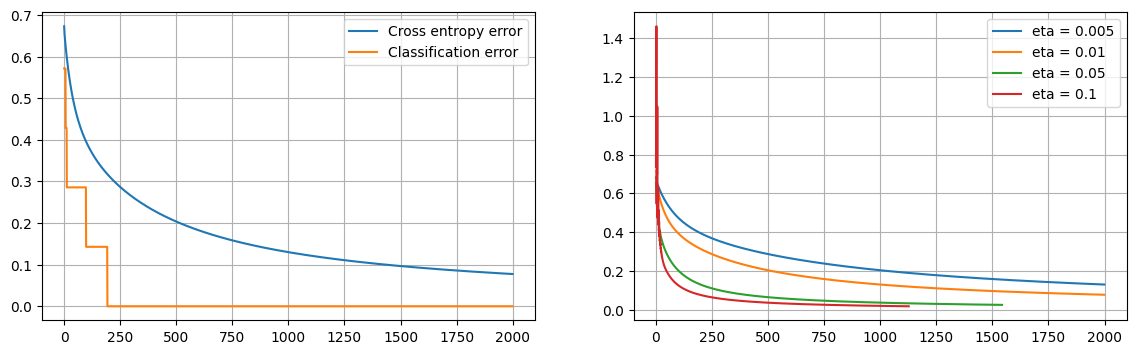

In [34]:
[weights3e, weights3e_track] = lr_train(seven_X, seven_y, trace=True)
#print(weights3e)

fi = PolynomialFeatures(1).fit_transform(seven_X)
h3e = lambda x: x >= 0.5 #jos uvijk radimo s (0,1)

etas = [0.005, 0.01, 0.05, 0.1]

crossen_err = [] #cross entropy loss
class_err = [] #zero one loss
lr_err = [] # errs za razlicite stope ucenja
#idemo od 0 do veličine stvorenih težina, po 3 koraka jer imamo 3 težine u svakoj iteraciji
for f in range(0, len(weights3e_track), 3): #tracked weights oblika [w0 w1 w2 w0 w1 w2 w0 w1 w2....]
  wgts1 = weights3e_track[f:f+3] #tezine u toj iteraciji
  class_err.append(zero_one_loss(seven_y, h3e(sigmoid(fi.dot(wgts1)))))
  crossen_err.append(cross_entropy_error(seven_X, seven_y, wgts1))


for i in etas:
  err_tmp = []
  [w3, w3_track] = lr_train(seven_X, seven_y, i, trace=True)

  for j in range(0, len(w3_track), 3):
    wgts2 = w3_track[j:j+3]
    err_tmp.append(cross_entropy_error(seven_X, seven_y, wgts2))

  lr_err.append(err_tmp)

plt.figure(figsize(14, 4))
plt.subplots_adjust(wspace=0.2)
plt.subplot(1,2,1)
plt.grid()
plt.plot(crossen_err)
plt.plot(class_err)
plt.legend(['Cross entropy error', 'Classification error'])

plt.subplot(1,2,2)
plt.grid()
for i in range(0, len(etas)):
    plt.plot(lr_err[i], label = 'eta = ' + str(etas[i]))

plt.legend(loc = 'best')
plt.show()


**Q:** Zašto je pogreška unakrsne entropije veća od pogreške klasifikacije? Je li to uvijek slučaj kod logističke regresije i zašto?

**Q:** Koju stopu učenja $\eta$ biste odabrali i zašto?

### (e)

Upoznajte se s klasom [`linear_model.LogisticRegression`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) koja implementira logističku regresiju. Usporedite rezultat modela na skupu `seven` s rezultatom koji dobivate pomoću vlastite implementacije algoritma.

**NB:** Kako ugrađena implementacija koristi naprednije verzije optimizacije funkcije, vrlo je vjerojatno da Vam se rješenja neće poklapati, ali generalne performanse modela bi trebale. Ponovno, pripazite na broj iteracija i snagu regularizacije.

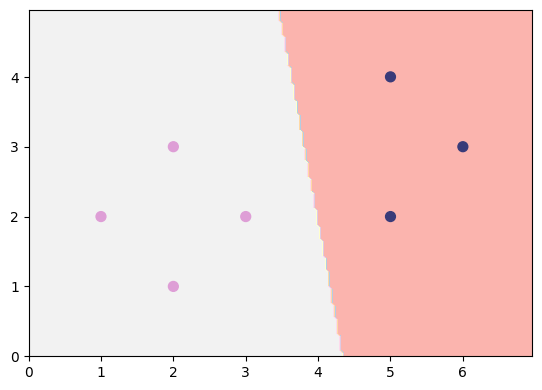

In [35]:
from sklearn.linear_model import LogisticRegression

logreg3e = LogisticRegression(max_iter=2000, tol=0.0001, C=0.01**-1).fit(seven_X,seven_y)

plt.figure(figsize(6.5, 4.5))
plot_2d_clf_problem(seven_X,seven_y, logreg3e.predict)

### 4. Analiza logističke regresije

### (a)

Koristeći ugrađenu implementaciju logističke regresije, provjerite kako se logistička regresija nosi s vrijednostima koje odskaču. Iskoristite skup `outlier`. Prikažite granicu između klasa.

In [36]:
outlier_X = np.append(seven_X, [[12,8]], axis=0)
outlier_y = np.append(seven_y, 0)

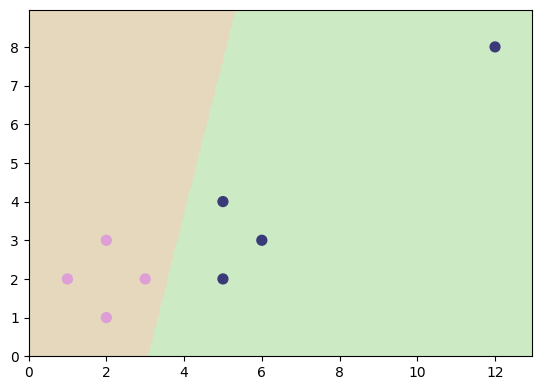

In [37]:
weights4a = lr_train(outlier_X, outlier_y, alpha = 0)

plt.figure(figsize(6.5, 4.5))
plot_2d_clf_problem(outlier_X, outlier_y, lambda x: lr_h(x, weights4a) >= 0.5)

**Q:** Zašto se rezultat razlikuje od onog koji je dobio model klasifikacije linearnom regresijom iz prvog zadatka?

### (b)

Trenirajte model logističke regresije na skupu `seven` te na dva odvojena grafikona prikažite, kroz iteracije optimizacijskoga algoritma, (1) izlaz modela $h(\mathbf{x})$ za svih sedam primjera te (2) vrijednosti težina $w_0$, $w_1$, $w_2$.

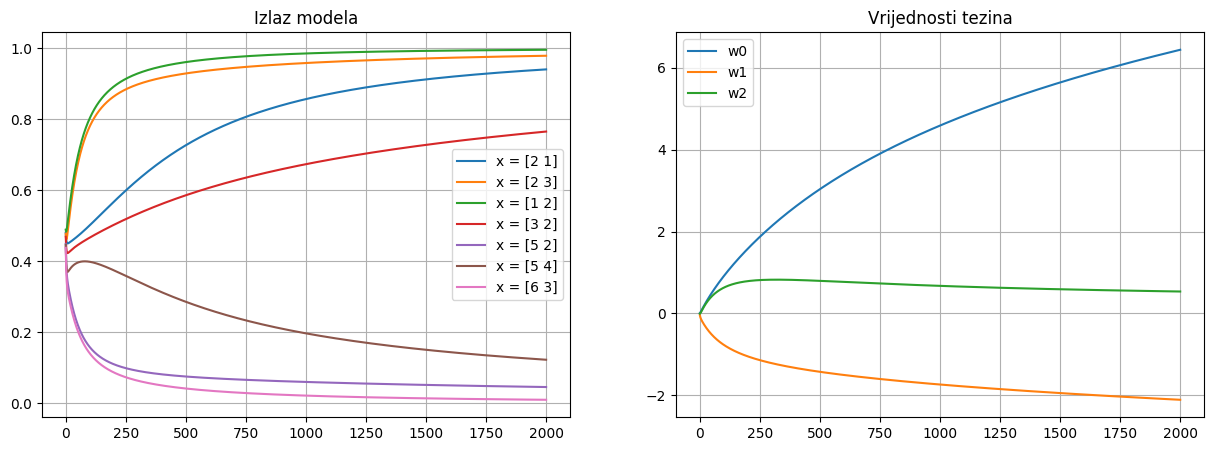

In [38]:
[weights4b, weights4b_track] = lr_train(seven_X, seven_y, trace = True)

w0_4b = []
w1_4b = []
w2_4b = []

for i in range(0, len(weights4b_track), 3):
  w0_4b.append(weights4b_track[i])
  w1_4b.append(weights4b_track[i+1])
  w2_4b.append(weights4b_track[i+2])

out_h = []

for i in range(0, len(seven_X)):
  h_tmp = []

  for v in range(0, len(weights4b_track), 3):
    wgts= weights4b_track[v:v+3]
    h_tmp.append(lr_h(seven_X[i], wgts))

  out_h.append(h_tmp)


plt.figure(figsize(15, 5))
plt.subplots_adjust(wspace=0.2)
plt.subplot(1,2,1)
plt.grid()
for i in range(0, len(out_h)):
  plt.plot(out_h[i], label = 'x = ' + str(seven_X[i]))
plt.title('Izlaz modela')
plt.legend()


plt.subplot(1,2,2)
plt.grid()
plt.plot(w0_4b)
plt.plot(w1_4b)
plt.plot(w2_4b);
plt.legend(['w0', 'w1', 'w2'])
plt.title('Vrijednosti tezina')
plt.show()

### (c)

Ponovite eksperiment iz podzadatka (b) koristeći linearno neodvojiv skup podataka `unsep`.

In [39]:
unsep_X = np.append(seven_X, [[2,2]], axis=0)
unsep_y = np.append(seven_y, 0)

epsilon uvjet na i = 1315


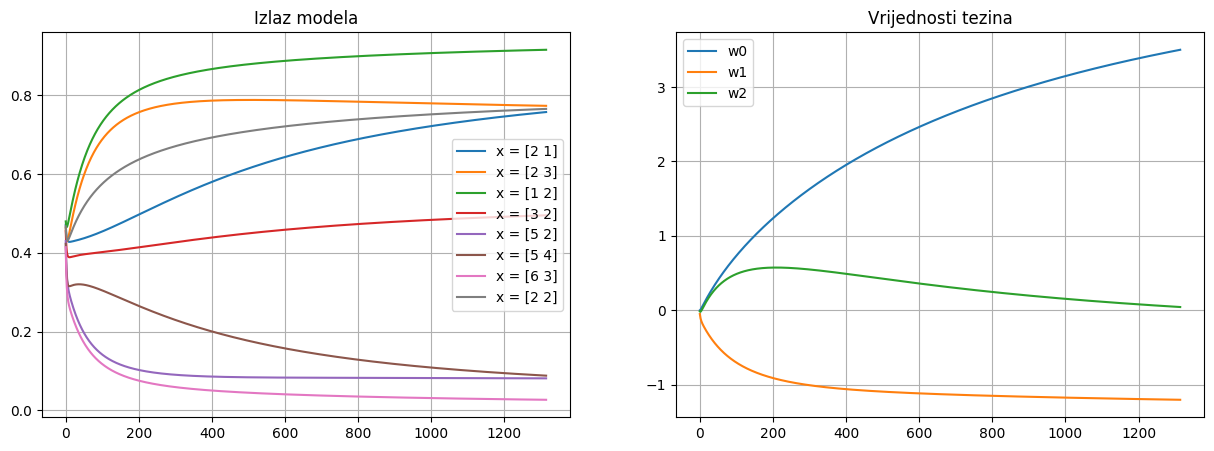

In [40]:
[weights4c, weights4c_track] = lr_train(unsep_X, unsep_y, trace = True)

w0_4c = []
w1_4c = []
w2_4c = []

for i in range(0, len(weights4c_track), 3):
  w0_4c.append(weights4c_track[i])
  w1_4c.append(weights4c_track[i+1])
  w2_4c.append(weights4c_track[i+2])

out_h = []

for i in range(0, len(unsep_X)):
  h_tmp = []

  for v in range(0, len(weights4c_track), 3):
    wgts= weights4c_track[v:v+3]
    h_tmp.append(lr_h(unsep_X[i], wgts))

  out_h.append(h_tmp)


plt.figure(figsize(15, 5))
plt.subplots_adjust(wspace=0.2)
plt.subplot(1,2,1)
plt.grid()
for i in range(0, len(out_h)):
  plt.plot(out_h[i], label = 'x = ' + str(unsep_X[i]))
plt.title('Izlaz modela')
plt.legend()


plt.subplot(1,2,2)
plt.grid()
plt.plot(w0_4c)
plt.plot(w1_4c)
plt.plot(w2_4c);
plt.legend(['w0', 'w1', 'w2'])
plt.title('Vrijednosti tezina')
plt.show()

**Q:** Usporedite grafikone za slučaj linearno odvojivih i linearno neodvojivih primjera te komentirajte razliku.

### 5. Regularizirana logistička regresija

Trenirajte model logističke regresije na skupu `seven` s različitim faktorima L2-regularizacije, $\alpha\in\{0,1,10,100\}$. Prikažite na dva odvojena grafikona (1) pogrešku unakrsne entropije te (2) L2-normu vektora $\mathbf{w}$ kroz iteracije optimizacijskog algoritma.

In [ ]:
from numpy.linalg import norm

epsilon uvjet na i = 772
epsilon uvjet na i = 230


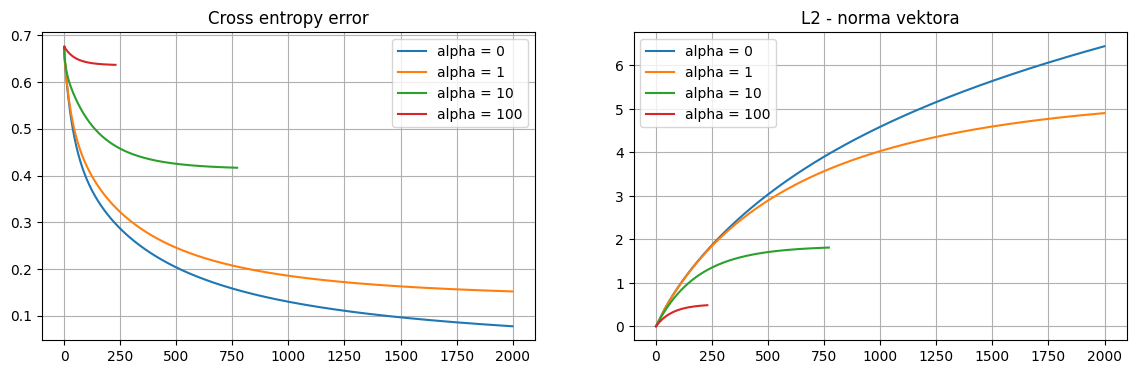

In [41]:
#[weights5, weights5_track] = lr_train(seven_X, seven_y, trace=True)
alphas = [0, 1, 10, 100]
errs=[]
norms=[]
for i in alphas:
  err=[]
  l2n =[]
  [w5, w5_track] = lr_train(seven_X, seven_y, alpha= i, trace=True)

  for j in range(0, len(w5_track), 3):
    wgts = w5_track[j:j+3]
    err.append(cross_entropy_error(seven_X, seven_y, wgts))

    wgtsnorm = w5_track[j:j+1]
    l2n.append(linalg.norm(wgtsnorm))
  errs.append(err)
  norms.append(l2n)


plt.figure(figsize(14, 4))
plt.subplots_adjust(wspace=0.2)
plt.subplot(1,2,1)
plt.grid()
for i in range(0, len(errs)):
    plt.plot(errs[i], label = 'alpha = '  + str(alphas[i]))

plt.title('Cross entropy error')
plt.legend()
plt.subplot(1,2,2)
plt.grid()
for i in range(0, len(errs)):
    plt.plot(norms[i], label = 'alpha = ' + str(alphas[i]) )

plt.title('L2 - norma vektora')
plt.legend()
plt.show()

**Q:** Jesu li izgledi krivulja očekivani i zašto?

**Q:** Koju biste vrijednost za $\alpha$ odabrali i zašto?

### 6. Logistička regresija s funkcijom preslikavanja

Proučite funkciju [`datasets.make_classification`](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html). Generirajte i prikažite dvoklasan skup podataka s ukupno $N=100$ dvodimenzijskih ($n=2)$ primjera, i to sa dvije grupe po klasi (`n_clusters_per_class=2`). Malo je izgledno da će tako generiran skup biti linearno odvojiv, međutim to nije problem jer primjere možemo preslikati u višedimenzijski prostor značajki pomoću klase [`preprocessing.PolynomialFeatures`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html), kao što smo to učinili kod linearne regresije u prvoj laboratorijskoj vježbi. Trenirajte model logističke regresije koristeći za preslikavanje u prostor značajki polinomijalnu funkciju stupnja $d=2$ i stupnja $d=3$. Prikažite dobivene granice između klasa. Možete koristiti svoju implementaciju, ali se radi brzine preporuča koristiti `linear_model.LogisticRegression`. Regularizacijski faktor odaberite po želji.

**NB:** Kao i ranije, za prikaz granice između klasa koristite funkciju `plot_2d_clf_problem`. Funkciji kao argumente predajte izvorni skup podataka, a preslikavanje u prostor značajki napravite unutar poziva funkcije `h` koja čini predikciju, na sljedeći način:

In [42]:
from sklearn.preprocessing import PolynomialFeatures

#plot_2d_clf_problem(X, y, lambda x : model.predict(poly.transform(x))

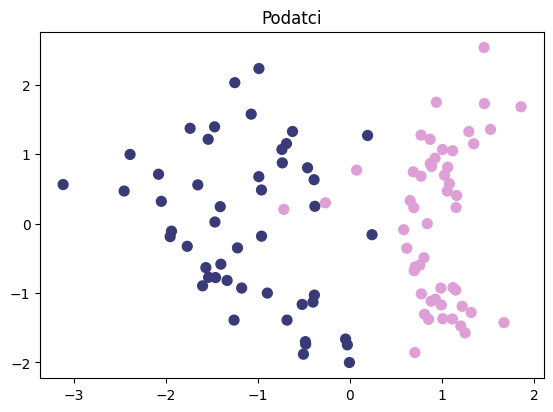

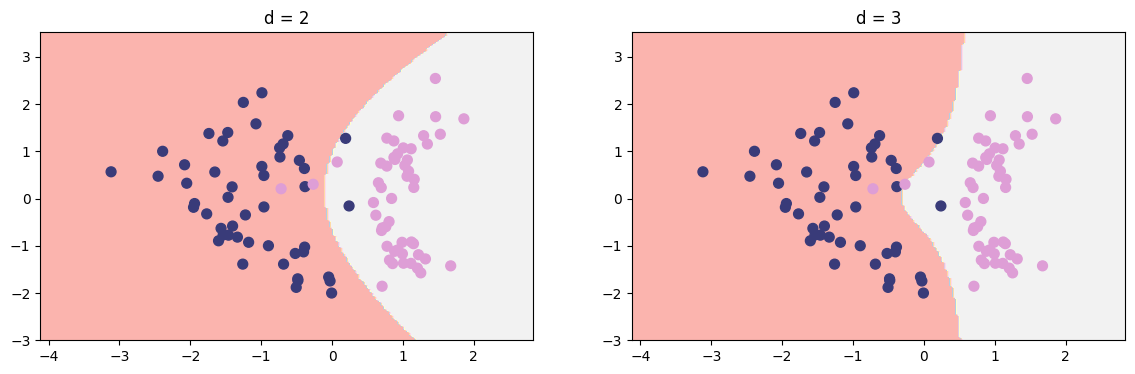

In [43]:
from sklearn.datasets import make_classification
dims = [2, 3]
count = 1
[X6a, y6a] = make_classification(n_samples=100, n_features=2, n_redundant=0, n_classes=2, n_clusters_per_class=2)

plt.figure(figsize(6.5, 4.5))
plot_2d_clf_problem(X6a, y6a)
plt.title('Podatci')

plt.figure(figsize(14, 4))
plt.subplots_adjust(wspace=0.2)
for d in dims:

  plt.subplot(1,2,count)
  pf = PolynomialFeatures(d)
  fi = pf.fit_transform(X6a)

  logreg6a = LogisticRegression()
  logreg6a = logreg6a.fit(fi, y6a)

  plot_2d_clf_problem(X6a, y6a, lambda x : logreg6a.predict(pf.transform(x)))
  plt.title('d = ' + str(d))
  count += 1

**Q:** Koji biste stupanj polinoma upotrijebili i zašto? Je li taj odabir povezan s odabirom regularizacijskog faktora $\alpha$? Zašto?